In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib

import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr
import scipy
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import NearestNeighbors
import math
import sys

stdout = sys.stdout

reload(sys)  
sys.setdefaultencoding('utf8')
sys.stdout = stdout

%config InlineBackend.figure_format = 'png' #set 'png' here when working on notebook
%matplotlib inline

In [2]:
train = pd.read_csv("treino.csv")
test = pd.read_csv("teste.csv")
train.head()

,matricula,Vetorial,LPT,P1,IC,LP1,Cálculo2,Discreta,P2,Grafos,Fís.Clássica,LP2,cra,Cálculo1
0,0cc3d63edf0b986cb87e345972857e15,8.6,10.0,9.0,9.1,8.6,8.4,8.3,8.8,8.2,7.9,9.4,8.477647,8.7
1,0d78246db769dc958ce19fc414050b2a,5.6,7.0,7.7,7.0,8.1,6.2,7.3,8.2,5.4,7.7,8.9,6.851724,7.0
2,0f5bb983df06b90337dc2c6301fef3f6,10.0,9.8,7.9,9.6,8.3,8.7,8.8,9.5,9.2,8.6,9.7,9.090588,8.6
3,1307a4421a67a497cea198e8ccfb97ee,6.1,8.3,6.8,8.2,7.1,8.0,6.3,8.9,7.0,8.5,9.0,7.283516,7.8
4,1432d50cf8519694ab992c414d90a130,8.8,9.3,5.0,8.5,5.1,5.0,5.8,7.1,5.4,8.7,8.2,7.205747,5.2


In [3]:
def draw_charts(labels, features):
    for i in labels:    
        matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
        df_hist = pd.DataFrame({i : features[i], "log(" +  i + " + 1)":np.log1p(features[i])})
        df_hist.hist()

In [4]:
def treatingDummieData(features):
    features = pd.get_dummies(features)
    return features

In [5]:
def fillNA(features):
    features = features.fillna(features.mean())
    return features

In [6]:
all_train_x = train.loc[:,'Vetorial':'Cálculo1']
all_test_x = test.loc[:,'Cálculo1':'LP2']

cra_train_y = train.loc[:,'cra']
cra_test_y = test.loc[:,'cra']
all_train_x = all_train_x.drop('cra', axis=1)

all_test_x = treatingDummieData(all_test_x)
all_test_x = fillNA(all_test_x)

all_train_x = treatingDummieData(all_train_x)
all_train_x = fillNA(all_train_x)


#data_labels = all_train_x[0:0]


In [7]:
def logTransformation(labels, features):
    transformed = []
    p_values = []
    for label in labels:
        features[label] = (np.log1p(features[label]))
    p_values = normalityTest(labels, features)
    return p_values

In [8]:
#Analisando tanto os gráficos e os valores para os p_values antes e apos a transformacao logaritmica,
#pode-se perceber que apenas tres variaveis sao normais, de acordo com o teste de normalidade utilizado,
#sendo elas: LPT, IC e Grafos. As transformacoes logaritmicas nao influenciaram significativamente nos 
#resultados.

In [9]:
#Neste ponto, pode-se observar a inclinacao dos dados, ou seja, o quao enviesados para esquerda ou direita eles
#estao

In [10]:
#partial_data = treatingDummieData(treatingDummieData)
#partial_data = fillNA(all_data)

In [11]:
def buildRidgeModel(X, Y, alpha):
    model = Ridge(alpha)
    model.fit(X, Y)
    return model

In [12]:
def buildLassoModel(X, Y, alpha):
    model = Lasso(alpha)
    model.fit(X,Y)
    return model

In [13]:
def buildKNN(X):
    model = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(X)
    return model

In [14]:
def cross_validation(model, X, Y, cv, scoring):
    scores = cross_val_score(model, X, Y, cv=cv, scoring=scoring)
    return scores

In [15]:
def calculateRMSE(scores):
    mse = 0
    for i in scores:
        mse = mse + (i ** 2)  
    rmse = np.sqrt(mse)
    return rmse

In [25]:
def plot_data(scores, Y, title):
    matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)
    preds = pd.DataFrame({"preds":scores, "true":Y})
    preds["residuals"] = preds["true"] - preds["preds"]
    preds.plot(x = "preds", y = "residuals",kind = "scatter", title = title)
    

In [26]:
#modelRidge = buildRidgeModel(all_train_x, cra_train_y, 0.0)
modelRidge = Ridge()
modelLasso = Lasso()
modelKNN = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(all_train_x)

In [27]:
#cross valid
scoresRidge = cross_validation(modelRidge, all_train_x, cra_train_y, 10, 'mean_squared_error')
scoresLasso = cross_validation(modelLasso, all_train_x, cra_train_y, 10, 'mean_squared_error')

modelRidge = buildRidgeModel(all_train_x, cra_train_y, scoresRidge.mean())
modelLasso = buildLassoModel(all_train_x, cra_train_y, scoresLasso.mean())

predRidge = modelRidge.predict(all_test_x)
predLasso = modelLasso.predict(all_test_x)
print("For Ridge -> Mean squared error: %.2f" % mean_squared_error(cra_test_y, predRidge))
print('For Ridge -> R-squared: %.2f' % r2_score(cra_test_y, predRidge))
print ("Ridge RMSE -> " , calculateRMSE(scoresRidge))
print
print("For Lasso -> Mean squared error: %.2f" % mean_squared_error(cra_test_y, predLasso))
print('For Lasso -> R-squared: %.2f' % r2_score(cra_test_y, predLasso))
print ("Lasso RMSE -> " , calculateRMSE(scoresLasso))

For Ridge -> Mean squared error: 0.17
For Ridge -> R-squared: 0.63
('Ridge RMSE -> ', 1.1961165893114565)

For Lasso -> Mean squared error: 57.51
For Lasso -> R-squared: -125.23
('Lasso RMSE -> ', 2.5449562093059437)


Residuos para para p Ridge: 


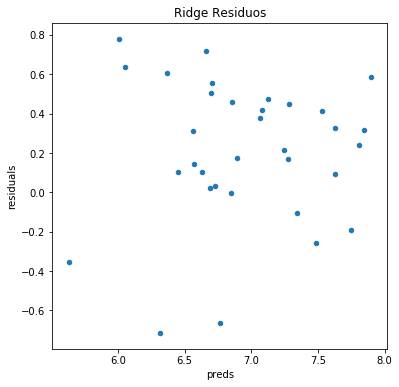

In [28]:
#let's look at the residuals as well:
print ("Residuos para para p Ridge: ")
plot_data(predRidge, cra_test_y, "Ridge Residuos")

Rsiduos para para p Lasso: 


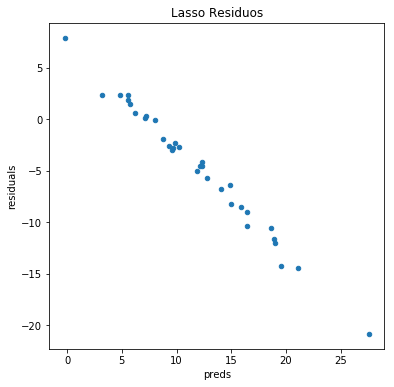

In [31]:
#let's look at the residuals as well:
print ("Rsiduos para para p Lasso: ")
plot_data(predLasso, cra_test_y, "Lasso Residuos")

In [ ]:
#Quanto aos residuos, pode-se notar que o modelo Ridge apresenta residuos aleatoriamente distribuitos.
#Ja para o Lasso, os residuos parecem seguir um determinado padrao, demonstrando que o modelo nao esta
#bem tunado para os dados apresentados.